In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer

import yasa

In [2]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [3]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


In [4]:
xtrain_eeg1.head()

x1        x2        x3       x4        x5       x6        x7  \
0  0.000400  0.000470  0.000067 -0.00016 -0.000003  0.00031  0.000360   
1  0.000067  0.000095  0.000270  0.00028  0.000250  0.00012  0.000094   
2  0.000160 -0.000210 -0.000840 -0.00120 -0.001200 -0.00140 -0.001400   
3 -0.000140  0.000260  0.000390  0.00043  0.000280  0.00023  0.000390   
4 -0.001100 -0.000790 -0.000081  0.00014  0.000200 -0.00014 -0.000430   

        x8        x9      x10  ...      x503      x504      x505      x506  \
0  0.00019 -0.000072 -0.00007  ... -0.000086  0.000033 -0.000046 -0.000270   
1 -0.00034 -0.000960 -0.00120  ...  0.000046  0.000300  0.000630  0.000710   
2 -0.00091 -0.000600 -0.00027  ... -0.000680 -0.000880 -0.001000 -0.000770   
3  0.00022  0.000150  0.00022  ...  0.000720  0.000760  0.000380  0.000052   
4 -0.00053 -0.000580 -0.00041  ...  0.000290  0.000600  0.000670  0.000190   

       x507     x508     x509     x510      x511      x512  
0 -0.000390 -0.00034 -0.00032 -0.00021  0.000042  0.000053  
1  0.000520  0.00041  0.00066  0.00088  0.000770  0.000410  
2 -0.000680 -0.00073 -0.00073 -0.00062 -0.000550 -0.000540  
3 -0.000260 -0.00058 -0.00075 -0.00110 -0.001200 -0.001200  
4 -0.000055 -0.00016 -0.00023 -0.00023 -0.000330 -0.000810  

[5 rows x 512 columns]

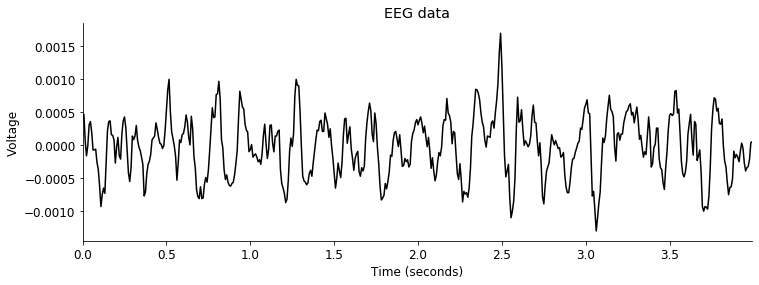

In [107]:
signal = xtrain_eeg1.iloc[0,:].values
# signal = xtrain_eeg1.values.ravel()

# Define sampling frequency and time vector
sf = 128.
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, signal, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

In [5]:
# Define function to extract features from eeg signal
# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_features_eeg(eeg_signal, frequency = 128):
    for i in (np.arange(eeg_signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(eeg_signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(eeg_signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(eeg_signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

def simple_statistics(sig, fs=128):
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(sig.shape) > 1) and (sig.shape[1]!=1):
        return np.array([np.mean(sig, axis=1), np.median(sig, axis=1),
                    np.std(sig, axis=1), np.max(sig, axis=1),
                    np.min(sig, axis=1), kurtosis(sig, axis=1),
                    skew(sig, axis=1)]).T
    else:
        print("Not Tested with this input!")
        return np.array([np.mean(sig), np.median(sig), np.std(sig),
                np.max(sig), np.min(sig), float(kurtosis(sig)),
                float(skew(sig))])

In [6]:
xtrain1 = extract_features_eeg(xtrain_eeg1, 128)
xtrain2 = extract_features_eeg(xtrain_eeg2, 128)
xtrain2 = xtrain2.rename(columns = {"Delta": "Delta2", "Theta": "Theta2", "Alpha": "Alpha2",
                         "Beta": "Beta2", "Gamma": "Gamma2"})
xtrain_eeg = xtrain1.join(xtrain2)
xtrain_eeg.head()

Delta     Theta     Alpha      Beta     Gamma    Delta2    Theta2  \
0  0.167779  0.589067  0.142509  0.084657  0.015988  0.145824  0.627337   
1  0.261716  0.384270  0.197637  0.141042  0.015335  0.274465  0.360708   
2  0.294706  0.191459  0.337027  0.158918  0.017890  0.360250  0.224307   
3  0.168293  0.581209  0.130216  0.105173  0.015109  0.129359  0.648551   
4  0.239408  0.542883  0.131650  0.076140  0.009920  0.118469  0.635031   

     Alpha2     Beta2    Gamma2  
0  0.140520  0.068544  0.017776  
1  0.230005  0.116119  0.018703  
2  0.271524  0.124966  0.018952  
3  0.135427  0.074995  0.011668  
4  0.127040  0.107246  0.012214

In [7]:
stats = simple_statistics(xtrain_eeg1)
stats1 = pd.DataFrame({"Mean": stats[:,0], "Median": stats[:,1], "Std": stats[:,2],
             "Max": stats[:,3], "Min": stats[:,4], "Kurtosis": stats[:,5], "Skew": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats1)
stats = simple_statistics(xtrain_eeg2)
stats2 = pd.DataFrame({"Mean2": stats[:,0], "Median2": stats[:,1], "Std2": stats[:,2],
             "Max2": stats[:,3], "Min2": stats[:,4], "Kurtosis2": stats[:,5], "Skew2": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats2)
stats = simple_statistics(xtrain_emg)
stats3 = pd.DataFrame({"Mean_emg": stats[:,0], "Median_emg": stats[:,1], "Std_emg": stats[:,2],
             "Max_emg": stats[:,3], "Min_emg": stats[:,4], "Kurtosis_emg": stats[:,5], "Skew_emg": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats3)
xtrain_eeg.head()

Delta     Theta     Alpha      Beta     Gamma    Delta2    Theta2  \
0  0.167779  0.589067  0.142509  0.084657  0.015988  0.145824  0.627337   
1  0.261716  0.384270  0.197637  0.141042  0.015335  0.274465  0.360708   
2  0.294706  0.191459  0.337027  0.158918  0.017890  0.360250  0.224307   
3  0.168293  0.581209  0.130216  0.105173  0.015109  0.129359  0.648551   
4  0.239408  0.542883  0.131650  0.076140  0.009920  0.118469  0.635031   

     Alpha2     Beta2    Gamma2  ...    Min2  Kurtosis2     Skew2  Mean_emg  \
0  0.140520  0.068544  0.017776  ... -0.0010  -0.021401  0.281361 -0.000011   
1  0.230005  0.116119  0.018703  ... -0.0014   0.027530  0.120553 -0.000011   
2  0.271524  0.124966  0.018952  ... -0.0013  -0.533982  0.115975 -0.000010   
3  0.135427  0.074995  0.011668  ... -0.0011  -0.375035  0.241000 -0.000011   
4  0.127040  0.107246  0.012214  ... -0.0011  -0.575194  0.249662 -0.000010   

   Median_emg   Std_emg   Max_emg   Min_emg  Kurtosis_emg  Skew_emg  
0   -0.000010  0.000010  0.000030 -0.000070      8.316864 -1.815205  
1   -0.000010  0.000009  0.000025 -0.000063     10.255864 -2.176539  
2   -0.000009  0.000008  0.000025 -0.000058      7.824936 -1.166946  
3   -0.000010  0.000009  0.000019 -0.000063     10.530290 -2.216652  
4   -0.000008  0.000008  0.000022 -0.000063     10.417868 -2.203634  

[5 rows x 31 columns]

In [8]:
## SVC APPROACH -- GRID-SEARCH CV

steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.3, 0.5, 0.7, 1, 5, 10],  
              "classifier__class_weight": ["balanced"],
              "classifier__degree": [1,3,5]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 2)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf, total=  25.4s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s remaining:    0.0s


[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf, total=  35.8s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=1, classifier__gamma=auto, classifier__kernel=rbf, total=  30.4s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=3, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=3, classifier__gamma=auto, classifier__kernel=rbf, total=  23.6s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=3, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__degree=3, classifier__gamma=auto, classifier__kernel=rbf, total=  33.8s
[CV] classifier__C=0.3, classifier__c

[CV]  classifier__C=1, classifier__class_weight=balanced, classifier__degree=3, classifier__gamma=auto, classifier__kernel=rbf, total=  28.1s
[CV] classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf, total=  19.6s
[CV] classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf, total=  33.0s
[CV] classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=1, classifier__class_weight=balanced, classifier__degree=5, classifier__gamma=auto, classifier__kernel=rbf, total=  29.0s
[CV] classifier__C=5, classifier__class_weight=bala

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 26.8min finished


0.9066483625277119
{'classifier__C': 0.3, 'classifier__class_weight': 'balanced', 'classifier__degree': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


Note: Compared performance with and without summary statistics. Marginally better with, 0.8596 vs 0.8541  
Update: Even better with summary statistics of emg added: 0.9066